In [ ]:
import numpy as np
from dataframe import Data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
from io_utils import *
from random import random
from filter import transient_filter
import pandas as pd
from filter import transient_filter_load_saved
from LightCurve import LightCurve

In [2]:
use_filter = False

In [3]:
dataset_val =1

In [4]:
if dataset_val == 0:
    dataset =  "PLAsTiCC"
    data_ob = load_PLAsTiCC_data()
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids=data_ob.get_ids_of_event_type(64)
    color_band_dict = {0:'C4',1:'C2', 2:'C3', 3:'C1', 4:'k', 5:'C5'}
    bands = [0,1,2,3,4,5]
    transient_filter_load_saved(data_ob=data_ob)
    #bands = [0,1,2,3,4,5]
    
if dataset_val == 1:    
    dataset = "ZTF"
    #data_ob = load_ztf_data()
    data_ob = load_ztf_train_data()
    
    object_ids = data_ob.get_all_object_ids()
    kilonova_ids = data_ob.get_ids_of_event_type(150)
    kilonova_ids = vstack([kilonova_ids, data_ob.get_ids_of_event_type(151)])
    kilonova_ids = kilonova_ids['SNID']
    data_ob.df_data.sort(['SNID','MJD'])
    data_ob.df_metadata.sort(['SNID'])
    
    bands = ['g', 'r']
    color_band_dict = {'g':'C2', 'r':'C3'}
    print(data_ob.df_data['FLT'])
    #transient_filter(data_ob=data_ob)

FLT
---
  g
  r
  r
  g
  r
  g
  g
  g
  r
  g
...
  g
  r
  g
  r
  g
  r
  g
  g
  r
  r
  g
Length = 303184 rows


In [5]:
bands = ['g', 'r']
band_map = {'g':'g', 'r':'r'}
color_band_dict = {'g':'C2', 'r':'C3'}

In [6]:
train_df = pd.read_csv('/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features.csv')

In [8]:
def plot_features_correlation_helper(features_df, bands, num_PC_components=3, color_band_dict=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= False, mark_ylabel= False, set_ax_title=False, band_map=None,label=""):
    
    num_rows = len(bands)
    num_cols = int(num_PC_components*(num_PC_components-1)/2)
    
    if fig is None:
        fig,axs = plt.subplots(num_rows,num_cols, figsize=(num_PC_components*5, len(bands)*5))
        #fig.subplots_adjust(wspace=.5,hspace=.5)
        ax_list = fig.axes
    else:
        ax_list = fig.axes
    
    if bands is None:
        bands = data_ob.band_map.keys()
        
    for i,band in enumerate(bands):
        for x in range(num_PC_components):
            for y in range(x):
                ax_current = ax_list[int(i*num_cols +(x-1)*(x)/2 +y)]
                
                colx_name = str(i)+"pc"+str(x+1)
                coly_name =str(i)+"pc"+str(y+1)
                if mark_xlabel: ax_current.set_xlabel("PC"+str(x+1))
                if mark_ylabel: ax_current.set_ylabel("PC"+str(y+1))  
                    
                PCx = features_df[colx_name].values
                PCy = features_df[coly_name].values

                if color_band_dict is not None:
                    ax_current.scatter(PCx,PCy, color = color_band_dict[band], alpha=.5, label=label)
                else:
                    ax_current.scatter(PCx, PCy, color = "yellow", alpha=.4, label = label)

                if x_limits is not None: ax_current.set_xlim(x_limits)
                if y_limits is not None: ax_current.set_ylim(y_limits)
                
                if set_ax_title: 
                    if band_map is None: ax_current.set_title("PCs for "+str(band)+"-band")
                    else : ax_current.set_title("PCs for "+str(band_map[band])+"-band")
                if label != "":
                    ax_current.legend(loc="upper right")
                ax_current.set_aspect('equal', 'box')
    fig.tight_layout()
    return fig

In [9]:
def plot_features_correlation(features_df, bands, num_PC_components =3, color_band_dict=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= True, mark_ylabel= True, band_map= None, set_ax_title=True, label=""):

    kn_df = features_df[train_df['y']==1]
    non_kn_df = features_df[train_df['y']==0]
    
    num_rows = len(bands)
    num_cols = int(num_PC_components*(num_PC_components-1)/2)
    
    fig,axs = plt.subplots(num_rows,num_cols, figsize=(num_PC_components*5, len(bands)*5))
    #fig.subplots_adjust(wspace=.5,hspace=.5)
    
    
    plot_features_correlation_helper(non_kn_df, fig = fig, num_PC_components = num_PC_components, band_map=band_map, color_band_dict=None, bands=bands,x_limits = x_limits, y_limits = y_limits, mark_xlabel= mark_xlabel, mark_ylabel= mark_ylabel, set_ax_title=set_ax_title, label="")
    plot_features_correlation_helper(kn_df, fig = fig, num_PC_components = num_PC_components, band_map=band_map, color_band_dict=color_band_dict, bands=bands,x_limits = x_limits, y_limits = y_limits, mark_xlabel= mark_xlabel, mark_ylabel= mark_ylabel, set_ax_title=set_ax_title, label="")
    
    plt.show() 

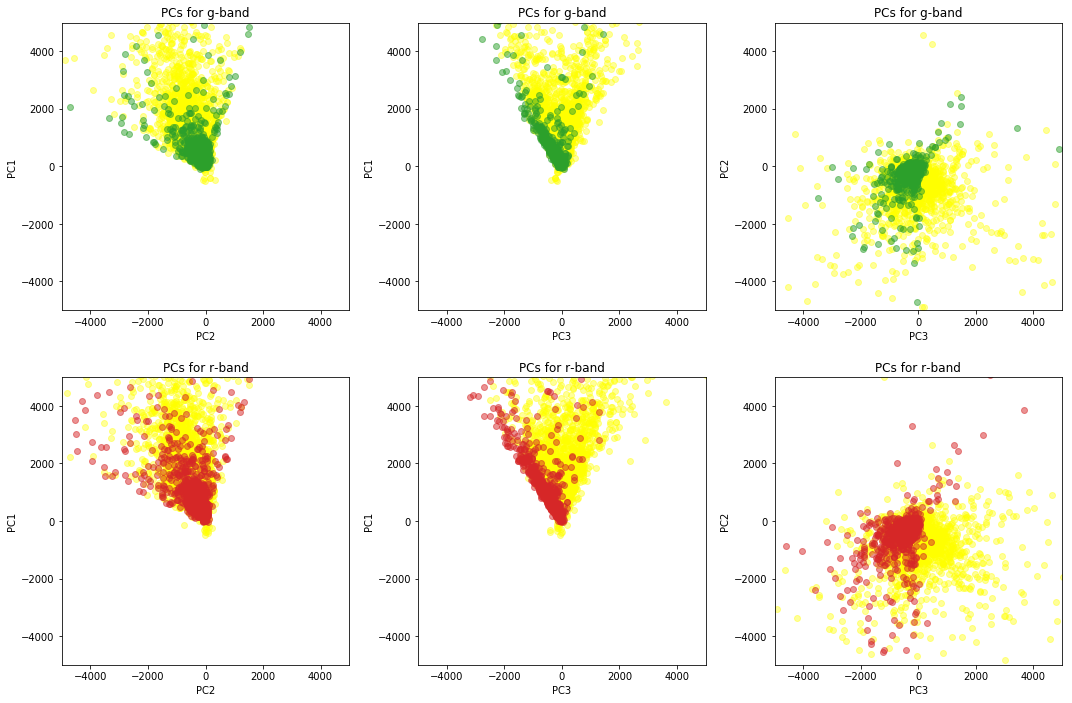

In [22]:
#print(train_df)
x_limits = (-5000,5000)
y_limits = (-5000,5000)
plot_features_correlation(train_df, bands = bands, color_band_dict=color_band_dict, x_limits=x_limits, y_limits=y_limits)

In [18]:
def plot_band_correlation_helper(features_df, bands, num_PC_components=3, color_band_dict=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= False, mark_ylabel= False, band_map = None, set_ax_title=False, label=""):
    num_rows = int(len(bands)*(len(bands)-1)/2)
    num_cols = num_PC_components
    if fig is None:
        fig,axs = plt.subplots(num_rows,num_cols, figsize=(num_PC_components*5, len(bands)*5))
        fig.subplots_adjust(wspace=.5,hspace=.5)
        ax_list = fig.axes
    else:
        ax_list = fig.axes
        
    for i in range(num_PC_components):
        #print("pc "+str(i))
        for x,band in enumerate(bands):
            for y in range(x):

                x_band = bands[x]
                y_band = bands[y]
                #print("x " +str(x))
                #print("y " +str(y))
                #print(int(i*len(bands)*(len(bands)-1)/2 + (x-1)*(x-2)/2 +y))
                ax_current = ax_list[int(i*num_rows +(x-1)*(x-2)/2 +y)]
            
                colx_name = str(x)+"pc"+str(i+1)
                coly_name = str(y)+"pc"+str(i+1)

                #print(coeff_plot_data)
                PCx = features_df[colx_name].values
                PCy = features_df[coly_name].values

                if color_band_dict is not None:
                    ax_current.scatter(PCx,PCy, color = color_band_dict[band], alpha=.5, label=label)
                else:
                    ax_current.scatter(PCx, PCy, color = "yellow", alpha=.4, label = label)

                if x_limits is not None: ax_current.set_xlim(x_limits)
                if y_limits is not None: ax_current.set_ylim(y_limits)
                if band_map is None:
                    if mark_xlabel: ax_current.set_xlabel(x_band+" band")
                    if mark_ylabel: ax_current.set_ylabel(y_band+" band")
                else: 
                    if mark_xlabel: ax_current.set_xlabel(band_map[x_band]+" band")
                    if mark_ylabel: ax_current.set_ylabel(band_map[y_band]+" band")
                if set_ax_title: ax_current.set_title("correlation for PC"+str(i+1))
                if label != "":
                    ax_current.legend(loc="upper right")
                ax_current.set_aspect('equal', 'box')
                
    fig.tight_layout()
    return fig

In [19]:
def plot_band_correlation(features_df, bands, num_PC_components =3, color_band_dict=None, fig=None, x_limits = None, y_limits = None, mark_xlabel= True, mark_ylabel= True, band_map = None,set_ax_title=True, label=""):

    kn_df = features_df[train_df['y']==1]
    non_kn_df = features_df[train_df['y']==0]
    
    num_rows = int(len(bands)*(len(bands)-1)/2)
    num_cols = num_PC_components
    space_between_axes = 0.0 
    
    
    fig,axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, num_rows*5))
    #fig.subplots_adjust(wspace=space_between_axes,hspace=space_between_axes)
    plot_band_correlation_helper(non_kn_df, bands=bands, fig = fig, num_PC_components = num_PC_components, color_band_dict=None, band_map=band_map,x_limits = x_limits, y_limits = y_limits, mark_xlabel= mark_xlabel, mark_ylabel= mark_ylabel, set_ax_title=set_ax_title, label="")
    plot_band_correlation_helper(kn_df, bands=bands, fig = fig, num_PC_components = num_PC_components, color_band_dict=color_band_dict, band_map=band_map, x_limits = x_limits, y_limits = y_limits, mark_xlabel= mark_xlabel, mark_ylabel= mark_ylabel, set_ax_title=set_ax_title, label="")
    #plt.xlabel(" correlation ")
    
    plt.show()
    

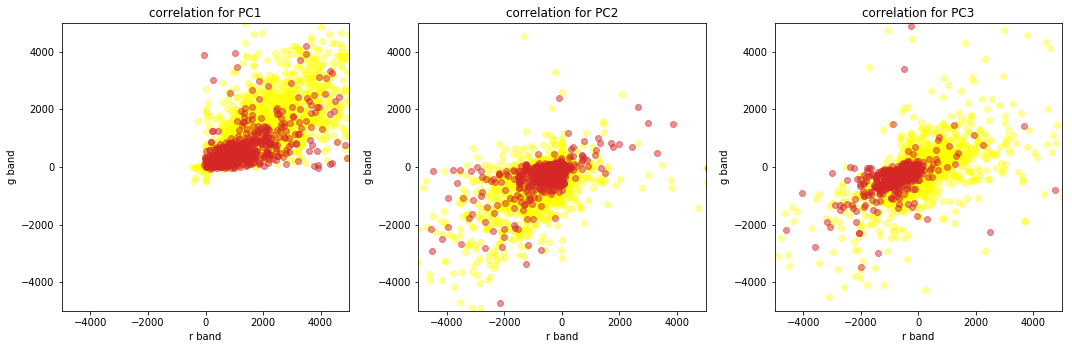

In [21]:
#print(train_df)
x_limits = (-5000,5000)
y_limits = (-5000,5000)
plot_band_correlation(train_df, color_band_dict=color_band_dict, bands = bands,x_limits=x_limits, y_limits=y_limits)